<a href="https://colab.research.google.com/github/shdocea/Snip/blob/master/Shea_chordHMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# chordHMM: A Hidden Markov Model Approach for Predicting Chord Relationships

This Google Colab walks the user through the process of training a bunch of HMM models and analyzing their output.

The user should be able to run each cell in order without any issues, but if anything breaks, restart the runtime and re-run.

# Global Variables: where you tailor the code to your needs

# *The following cell is the only one you need to edit*

**Bookeeping**: You need to make sure your own google drive has a folder called "hmm_models" (all lowercase!)

**Critical modeling choices**: You need to make some decisions as to how big and complex your model is going to be.

*   NUM_RUNS sets how many times the process creates a potential solution for each number of "functions." The higher the number, the more precise your results, but the longer the process takes to complete. To test the system, try 5-10; for a straightforward sequence with only a few chords that act very regulalarly, try 50-100. For more complicated project, try between 300 and 500.
*   How wide of a next do you want the process to cast when looking for good numebrs of hidden states (or, "functions")? The variables MIN_NUM_STATES and MAX_NUM_STATES are the lower and upper bounds of this search. *If you set these for 2 and 12, for instance, the program will make HMMs with 2 states, 3 states, 4 states, all the way to 12 states.*

**Formatting choices**: You need to make sure the program knows which columns to look at in your spreadsheet to find various pieces of information. In this programming universe, the first column is column Zero, so if some information was in what your spreadsheet calls "Column A", that row would = 0; "Column C" would = 2, and so on.


*   Many datasets indicate where in a piece an event occurs (indications like: *12.2 seconds into the track* or *the second beat of the fourth measure* or *22.5 quarter notes into the piece*. OFFSET_ROWNUM indicates the column where this type of information is found. If your corpus doesn't have this information, the program still wants to be able to order the chord symbols. For this reason, I will add ordered numbers (1, 2, 3... etc) in some column for corpora that do not originally contain this information.
*   The focus of the HMM is in CURRENT_CHORD_ROWNUM. For instance, if your corpus is a series of chords or Roman numeral, they should be in this row.
*   CURR_PIECE_ROWNUM has the names of the pieces or tracks from which the chords are being drawn. The current implementation does not foreground this information, so if your corpus does not contain these names, you can just populate some column with a dummy symbol (like: fill a some column with the letter "X" and point to that as the CURR_PIECE_ROWNUM column).
*   KEY_ROWNUM indicates what tonal center is associated with each chord. Again, this information is not foregrounded in this implementation, so if you don't want to use it, you can fill a column with some random information (like: fill some column with the letter "X" and point to that as the KEY_ROWNUM column). The current implementation is designed to skip over any series whose key is labeled "Ambiguous".
*   MODE_ROWNUM points to the column with mode information. By default, the model only observes major mode pieces, so be sure your major-mode pieces are labeled as "Major" in this column. If your corpus does not contain this information (or if you'd rather the program consider all available chords), populate a column with the word "Major" and point to that as the MODE_ROWNUM column.

In this implementation, you can ignore WHICH_RUN. It's designed to be able to allow for different versions ("runs") of this program to be stored in the same folder in your Google Drive.

If ever you need to reset these variables, just change them here and rerun this cell.

In [ ]:
# Tells Google Colab where to put your chordHMM output. Make sure to keep the "/content/gdrive/My Drive/" part.
# Also make sure that it ends with a forward slash "/".
OUTPUT_DIRECTORY = '/content/gdrive/My Drive/hmm_models/'

NUM_RUNS = 30  # This determines the number of models are generated per number of states.

# The following 2 variables define the range for the number of states generated.
MIN_NUM_STATES = 2
MAX_NUM_STATES = 16

# For your training and test sets, customize the below global variables
# to allow the HMM to read the format of your spreadsheets.
# See the example table above.
OFFSET_ROWNUM = 4 #s.index
CURRENT_CHORD_ROWNUM = 3 #f.s column
CURR_PIECE_ROWNUM = 1 #file.name column
KEY_ROWNUM = 5  # This is used to check whether the key label is "Ambiguous", which is a feature specifically of the YCAC
MODE_ROWNUM = 2

# For post-training analysis: Choose a specific run to align your clusters/silhouette data with.
WHICH_RUN = 1

# Initialize Datasets/Packages

These cells are going to ask you to upload a training set and a dataset. They can absolutely be the same, but if you'd like to use one portion of your corpus to train your model and another portion to create analyses, you can divide your corpus and select different files. There should be a popup window that allows for you to select a dataset from your computer, but if you'd like to use a premade corpus, [download this file](https://raw.githubusercontent.com/chriswmwhite/AIproject/main/KostkaPayne.csv) (It's a bunch of chords from David Temperley's [Kostka-Payne dataset](http://davidtemperley.com/kp-stats))

#When you see the "Chose Files" button pop up, press it to upload both the training and test sets!

The program also installs the music21 package. This package is used for modelling chords for data analysis. See the [website](http://web.mit.edu/music21/) for more info.

In [ ]:
pip install music21

Allow Google Colab access to your Google Drive to read/write files. If your connection breaks during the later part of this Colab, just re-run this cell to ensure that your files can be accessed.

In [ ]:
from google.colab import files, drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Then upload your training and test sets.

For reference, this was the format of our dataset. The only relevant columns  here are offset, Scale Degrees, Piece, Key, and Mode. If the format is different than this, you will have to change the "ROW_NUM" global variables in the **Global Variables** cell.

| offset | PCs In Normal Form | NEXTPc | Scale Degrees | file | Composer | Piece | Time Signature | Key | Mode | NEXTChord | PC1 | SetClass | SetClassBigram | SDBigram |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
0 | "[0, 4, 7]" | "[5, 9, 0]" | "[0, 4, 7]" | bach.annamin | bach | namin | "[4, 1, 0.5]" | 0 | Major | "[5, 9, 0]" | 0 | "[0, 4, 7]" | "[0, 4, 7]\_5\_[0, 4, 7]" | "[0, 4, 7]_[5, 9, 0]"
1 | "[5, 9, 0]" | "[0, 4, 7]" | "[5, 9, 0]" | bach.annamin | bach | namin | "[4, 1, 0.5]" | 0 | Major | "[0, 4, 7]" | 5 | "[0, 4, 7]" | "[0, 4, 7]\_7\_[0, 4, 7]" | "[5, 9, 0]_[0, 4, 7]"
2 | "[0, 4, 7]" | "[11, 2, 5]" | "[0, 4, 7]" | bach.annamin | bach | namin | "[4, 1, 0.5]" | 0 | Major | "[11, 2, 5]" | 0 | "[0, 4, 7]" | "[0, 4, 7]\_11\_[0, 3, 6]" | "[0, 4, 7]_[11, 2, 5]"
| ...



In [ ]:
# Upload your training set as csv files.

training_set = [f.replace('.csv', '') for f in files.upload().keys()]
print(training_set)

Saving rtrain.csv to rtrain.csv
['rtrain']


In [ ]:
# Upload your test set as csv files.

test_set = [f.replace('.csv', '') for f in files.upload().keys()]
print(test_set)

Saving rtest.csv to rtest.csv
['rtest']


Note: These files will be placed in your main "My Drive" directory on Google Drive, but will disappear once your connection expires.

# Training the Models

The following cell "chordHMM.py" contains the bulk of the source code for training. Be sure to run it!

# This will take awhile!
If you've got a small corpus with a small NUM_RUNS, this will be ten or fifteen minutes. A substantial corpus with a large NUM_RUNS could take a few hours or more!

In [ ]:
#@title chordHMM.py

"""
Python module for creating, training and applying hidden
Markov models to discrete or continuous observations.
Original Author: Michael Hamilton,  hamiltom@cs.colostate.edu
Theoretical concepts obtained from Rabiner, 1989.
Updated and modified for music by Chris White and Ian Quinn, 2012

"""
from __future__ import division
import csv
import json
import string
import random
import numpy
import pylab
import time
import copy
import os
from numpy import random as rand
from matplotlib import rc
from music21 import *


rc("text", usetex=True)
numpy.seterr(divide='ignore')

class HMM_Classifier:
    """
    A binary hmm classifier that utilizes two hmms: one corresponding
    to the positive activity and one corresponding to the negative
    activity.
    """

    def __init__(self, **args):
        """
        :Keywords:
          - `neg_hmm` - hmm corresponding to negative activity
          - `pos_hmm` - hmm corresponding to positive activity
        """
        self.neg_hmm = None
        self.pos_hmm = None

        if "neg_hmm" in args:
            self.neg_hmm = args["neg_hmm"]

        if "pos_hmm" in args:
            self.pos_hmm = args["pos_hmm"]

    def classify(self, sample):
        """
        Classification is performed by calculating the
        log odds for the positive activity.  Since the hmms
        return a log-likelihood (due to scaling)
        of the corresponding activity, the difference of
        the two log-likelihoods is the log odds.
        """
        # Scream if an hmm is missing
        if self.pos_hmm is None or self.neg_hmm is None:
            raise "pos/neg hmm(s) missing"

        pos_ll = forward(self.pos_hmm, sample, scaling=1)[0]
        neg_ll = forward(self.neg_hmm, sample, scaling=1)[0]

        # log odds by difference of log-likelihoods
        return pos_ll - neg_ll

    def add_pos_hmm(self, pos_hmm):
        """
        Add the hmm corresponding to positive
        activity.  Replaces current positive hmm, if it exists.
        """
        self.pos_hmm = pos_hmm

    def add_neg_hmm(self, neg_hmm):
        """
        Add the hmm corresponding to negative
        activity.  Replaces current negative hmm, if it exists.
        """
        self.neg_hmm = neg_hmm


class HMM:
    """
    Creates and maintains a hidden Markov model.  This version assumes the every state can be
    reached DIRECTLY from any other state (ergodic).  This, of course, excludes the start state.
    Hence the state transition matrix, A, must be N X N .  The observable symbol probability
    distributions are represented by an N X M matrix where M is the number of observation
    symbols.

                  |a_11 a_12 ... a_1N|                   |b_11 b_12 ... b_1M|
                  |a_21 a_22 ... a_2N|                   |b_21 b_22 ... b_2M|
              A = | .    .        .  |               B = | .    .        .  |
                  | .         .   .  |                   | .         .   .  |
                  |a_N1 a_N2 ... a_NN|                   |b_N1 b_N2 ... b_NM|

           a_ij = P(q_t = S_j|q_t-1 = S_i)       b_ik = P(v_k at t|q_t = S_i)
        where q_t is state at time t and v_k is k_th symbol of observation sequence
    """

    def __init__(self, n_states=1, **args):
        """
        :Keywords:
          - `n_states` - number of hidden states
          - `V` - list of all observable symbols
          - `A` - transition matrix
          - `B` - observable symbol probability distribution
          - `D` - dimensionality of continuous observations
          - `F` - Fixed emission probabilities for the given state ( dict: i -> numpy.array( [n_states] ),
                  where i is the state to hold fixed.
        """

        self.N = n_states  # Number of hidden states

        # Initialize observable symbol set parameters
        self.V = args["V"]
        self.M = len(self.V)
        self.symbol_map = dict(zip(self.V, range(len(self.V))))

        # print("MAP", self.symbol_map)
        # print("MAP1", self.symbol_map['[1, 4]'])

        # Initialize transition probability matrix
        if "A" in args:
            self.A = args["A"]
            assert numpy.shape(self.A) == (self.N, self.N)
        else:
            # Randomly initialize matrix and normalize so sum over a row = 1
            raw_A = rand.uniform(size=self.N * self.N).reshape((self.N, self.N))
            self.A = (raw_A.T / raw_A.T.sum(0)).T
            if n_states == 1:
                self.A.reshape((1, 1))

        # Initialize observable symbol probability distributions
        if "B" in args:
            self.B = args["B"]
            if n_states > 1:
                assert numpy.shape(self.B) == (self.N, self.M)
            else:
                self.B = numpy.reshape(self.B, (1, self.M))

            if "F" in args:
                self.F = args["F"]
                """
                the values of F are lists of probabilities that mirror the B matrix
                this replaces a row in B with that list from F
                """
                for i in self.F.keys():
                    # print("TESTING F", i, '\n')
                    if self.chatty:
                        print(self.F[i], "\n")
                    # print("TESTING B IS", B[i, :])
                    self.B[i, :] = self.F[i]  # self.B[i,:] give us the ith row of,
                    # print("AFTER", self.B[i,:])
            else:
                self.F = {}
        else:
            # initialize distribution
            B_raw = rand.uniform(0, 1, self.N * self.M).reshape((self.N, self.M))
            self.B = (B_raw.T / B_raw.T.sum(0)).T

            if "F" in args:
                self.F = args["F"]
                for i in self.F.keys():
                    self.B[i, :] = self.F[i]
            else:
                self.F = {}

        # Initialize the intitial state distribution
        if "Pi" in args:
            self.Pi = args["Pi"]
            assert len(self.Pi) == self.N
        else:
            # initialize to uniform distribution
            self.Pi = numpy.array(1.0 / self.N).repeat(self.N)

        if "Labels" in args:
            self.Labels = args["Labels"]
        else:
            self.Labels = range(self.N)

        if "F" in args:
            self.F = args["F"]
            for i in self.F.keys():
                self.B[i, :] = self.F[i]
        else:
            self.F = {}

    def __repr__(self):
        # print(self.A)
        retn = ""
        retn += "num hiddens: %d\n" % (self.N) + "symbols: %s\n" % (self.V) + "\nA:\n %s\n" % (str(self.A)) + "Pi:\n %s" % (str(self.Pi))

        return f"num hiddens: {self.N}\nsymbols: {self.V}\n\nA:\n {self.A}\nPi:\n {self.Pi}"


#######################################################################


def symbol_index(hmm, Obs):
    """
    Converts an obeservation symbol sequence into a sequence
    of indices for accessing distribution matrices.
    """
    Obs_ind = []
    for o in Obs:

        try:
            Obs_ind.append(hmm.symbol_map[o])
            # print("MAPPING", o, hmm.symbol_map[o])
        except:
            # print('I do not have a map for', o)
            continue

    return Obs_ind


#######################################################################


def forward(hmm, Obs, scaling=1):
    """
    Calculate the probability of an observation sequence, Obs,
    given the model, P(Obs|hmm).
    Obs: observation sequence
    hmm: model
    returns: P(Obs|hmm)
    """
    T = len(Obs)  # Number of states in observation sequence
    # Get index sequence of observation sequence to access
    # The observable symbol probabilty distribution matrix

    Obs = symbol_index(hmm, Obs)  # Now Obs is a list of integers which index the rows of B associated with the Observables

    # Create scaling vector
    if scaling:
        c = numpy.zeros([T], float)

    # Base Case:
    Alpha = numpy.zeros([hmm.N, T], float)

    Alpha[:, 0] = hmm.Pi * hmm.B[:, Obs[0]]
    # Alpha[ :,0] is now the output probs of the first observation times each value in Pi
    if scaling:
        c[0] = 1.0 / numpy.sum(Alpha[:, 0])
        Alpha[:, 0] = c[0] * Alpha[:, 0]

    # Induction Step:
    for t in range(1, T):
        Alpha[:, t] = numpy.dot(Alpha[:, t - 1], hmm.A) * hmm.B[:, Obs[t]]
        if scaling:
            c[t] = 1.0 / numpy.sum(Alpha[:, t])
            Alpha[:, t] *= c[t]

    if scaling:
        log_Prob_Obs = -(numpy.sum(numpy.log(c)))
        return (log_Prob_Obs, Alpha, c)
    else:
        prob_Obs = numpy.sum(Alpha[:, T - 1])
        return (prob_Obs, Alpha)


#######################################################################


def backward(hmm, Obs, c=None):
    """
    Calculate the probability of a partial observation sequence
    from t+1 to T, given some state t.
    Obs: observation sequence
    hmm: model
    c: the scaling coefficients from forward algorithm
    returns: B_t(i)
    """
    T = len(Obs)  # Number of states in observation sequence

    # Get index sequence of observation sequence to access
    # the observable symbol probabilty distribution matrix
    Obs = symbol_index(hmm, Obs)

    # Base Case:
    Beta = numpy.zeros([hmm.N, T], float)
    Beta[:, T - 1] = 1.0
    if c is not None:
        Beta[:, T - 1] = Beta[:, T - 1] * c[T - 1]
    # Inductive Step:
    for t in reversed(range(T - 1)):
        Beta[:, t] = numpy.dot(hmm.A, (hmm.B[:, Obs[t + 1]] * Beta[:, t + 1]))

        if c is not None:
            Beta[:, t] = Beta[:, t] * c[t]

    return Beta


#######################################################################


def viterbi(hmm, Obs, scaling=False):
    """
    Calculate P(Q|Obs, hmm) and yield the state sequence Q* that
    maximizes this probability.
    Obs: observation sequence
    hmm: model
    """

    T = len(Obs)  # Number of states in observation sequence

    # Get index sequence of observation sequence to access
    # the observable symbol probabilty distribution matrix
    Obs = symbol_index(hmm, Obs)

    # Initialization
    # Delta[ i,j ] = max_q1,q2,...,qt P( q1, q2,...,qt = i, O_1, O_2,...,O_t|hmm )
    # this is the highest prob along a single path at time t ending in state S_i
    Delta = numpy.zeros([hmm.N, T], float)

    if scaling:
        Delta[:, 0] = numpy.log(hmm.Pi) + numpy.log(hmm.B[:, Obs[0]])
        # this has a problem with zeros, if we want to use this in the future, make it leave zeros alone

    else:
        Delta[:, 0] = hmm.Pi * hmm.B[:, Obs[0]]

    # Track Maximal States
    Psi = numpy.zeros([hmm.N, T], int)

    # Inductive Step:
    if scaling:
        for t in range(1, T):
            nus = Delta[:, t - 1] + numpy.log(hmm.A)
            Delta[:, t] = nus.max(1) + numpy.log(hmm.B[:, Obs[t]])
            Psi[:, t] = nus.argmax(1)
    else:
        for t in range(1, T):
            nus = Delta[:, t - 1] * hmm.A
            try:
                Delta[:, t] = nus.max(1) * hmm.B[:, Obs[t]]
            except:
                pass
            Psi[:, t] = nus.argmax(1)

    # Calculate State Sequence, Q*:
    Q_star = [numpy.argmax(Delta[:, T - 1])]
    for t in reversed(range(T - 1)):
        Q_star.insert(0, Psi[Q_star[0], t + 1])

    return (Q_star, Delta, Psi)


#######################################################################


def baum_welch(hmm, Obs_seqs, **args):
    """
    EM algorithm to update Pi, A, and B for the HMM
    :Parameters:
      - `hmm` - HMM model to train
      - `Obs_seqs` - list of observation sequences to train over
    :Return:
      a trained HMM

    :Keywords:
      - `epochs` - number of iterations to perform EM, default is 20
      - `val_set` - validation data set, not required but recommended to prevent over-fitting
      - `updatePi` - flag to update initial state probabilities
      - `updateA` - flag to update transition probabilities, default is True
      - `updateB` - flag to update observation emission probabilites for discrete types, default is True
      - `scaling` - flag to scale probabilities (log scale), default is True
      - `graph` - flag to plot log-likelihoods of the training epochs, default is False
      - `normUpdate` - flag to use 1 / -(normed log-likelihood) contribution for each observation
                       sequence when updating model parameters, default if False
      - `fname` - file name to save plot figure, default is ll.eps
      - `verbose` - flag to print training times and log likelihoods for each training epoch, default is False
      - `corpus` - a chordCorpus object, containing observation sequences and an edit distance array
      - `chordHMM` - chordHMM is a class, using baum_wlech() in the method train()
    """

    # Setup keywords
    updatePi = updateA = updateB = scaling = 1
    normUpdate = verbose = validating = graph = 0
    if "updatePi" in args:
        updatePi = args["updatePi"]
    if "updateA" in args:
        updateA = args["updateA"]
    if "updateB" in args:
        updateB = args["updateB"]
    if "scaling" in args:
        scaling = args["scaling"]
    if "graph" in args:
        graph = args["graph"]
    if "normUpdate" in args:
        normUpdate = args["normUpdate"]
    if "fname" in args:
        fname = args["fname"]
    else:
        fname = "ll.eps"
    if "verbose" in args:
        verbose = args["verbose"]
    if "val_set" in args:
        validating = 1
        val_set = args["val_set"]
    if "corpus" in args:
        corpus = args["corpus"]
    else:
        print("I don't have a corpus")
    if "chordHMM" in args:
        chordHMM = args["chordHMM"]
    else:
        print("I don't have a chordHMM!")

    epochs = chordHMM.epochs
    K = len(Obs_seqs)  # Number of observation sequences
    start = time.time()  # Start training timer
    LLs = []  # Keep track of log likelihoods for each epoch
    val_LLs = []  # Keep track of validation log-likelihoods for each epoch

    # Store best parameters
    best_A = copy.deepcopy(hmm.A)
    best_B = copy.deepcopy(hmm.B)
    best_Pi = copy.deepcopy(hmm.Pi)
    best_epoch = "N/A"

    best_val_LL = None

    # a list of lists that contain distances between states for adjacent epoch pairs
    allDistances = []
    # Iterate over specified number of EM epochs
    for epoch in range(epochs):
        # print(hmm)
        previousHMM = copy.deepcopy(hmm)

        if chordHMM.chatty:
            print("Starting epoch", epoch + 1, "of", epochs)
        start_epoch = time.time()  # start epoch timer

        LL_epoch = 0  # intialize log-likelihood of all seqs given the model
        Expect_si_all = numpy.zeros([hmm.N], float)  # Expectation of being in state i over all seqs
        Expect_si_all_TM1 = numpy.zeros([hmm.N], float)  # Expectation of being in state i over all seqs until T-1
        Expect_si_sj_all = numpy.zeros([hmm.N, hmm.N], float)  # Expectation of transitioning from state i to state j over all seqs
        Expect_si_sj_all_TM1 = numpy.zeros([hmm.N, hmm.N], float)
        Expect_si_t0_all = numpy.zeros([hmm.N])  # Expectation of initially being in state i over all seqs
        Expect_si_vk_all = numpy.zeros([hmm.N, hmm.M], float)  # Expectation of being in state i and seeing symbol vk
        ow = 0
        for i, piece in enumerate(Obs_seqs):
            if ow > 0 and ow % 100 == 0:
                if chordHMM.chatty:
                    print("epoch %d: %d seqs processed" % (epoch + 1, ow))
            #            if i > 30:
            #                break
            ow += 1
            Obs = Obs_seqs[piece]
            if len(Obs) < 2:
                continue
            # print('piece is ', piece)
            log_Prob_Obs, Alpha, c = forward(hmm=hmm, Obs=Obs, scaling=1)  # Calculate forward probs, log-likelihood, and scaling vals
            # NOTES: We changed scaling to be zero, and had to get rid of 'c' in the returns
            Beta = backward(hmm=hmm, Obs=Obs, c=c)  # Calculate backward probs
            LL_epoch += log_Prob_Obs  # Update overall epoch log-likelihood
            T = len(Obs)  # Number of states in observation sequence

            # Determine update weight of the observation for contribution
            # to model parameter maximization

            if normUpdate:
                w_k = 1.0 / -(log_Prob_Obs + numpy.log(len(Obs)))
            else:
                w_k = 1.0

            # Get index sequence of observation sequence to access
            # the observable symbol probabilty distribution matrix
            Obs_symbols = Obs[:]
            Obs = symbol_index(hmm, Obs)

            # Calculate gammas
            # Gamma[ i,t ] = P( q_t = S_i|Obs, hmm)
            Gamma_raw = Alpha * Beta
            # print("Alpha is", Alpha)
            # print('beta is', Beta)
            # print('sum:', sum(Alpha[:,T-1]))
            # print("other", Gamma_raw.sum( 0 )[-1])
            # print('gamma', Gamma_raw)
            Gamma = Gamma_raw / Gamma_raw.sum(0)  # sum(Alpha[:T-1])

            Expect_si_t0_all += w_k * Gamma[:, 0]

            # Expect_si_all[ i ] = expected number of transitions from state i over all
            # training sequences.
            Expect_si_all += w_k * Gamma.sum(1)
            Expect_si_all_TM1 += w_k * Gamma[:, : T - 1].sum(1)

            # Calculate Xis
            # Xi is an N X N X T-1 matrix corresponding to
            # Xi[ i,j,t ] = P(q_t = S_i, q_t+1 = S_j|Obs, hmm )
            Xi = numpy.zeros([hmm.N, hmm.N, T - 1], float)
            T = len(Obs)  ##### THIS IS NEW, FOR SOME REASON, the LENGTH WAS GETTING F*CKY
            for t in range(T - 1):
                for i in range(hmm.N):
                    Xi[i, :, t] = Alpha[i, t] * hmm.A[i, :] * hmm.B[:, Obs[t + 1]] * Beta[:, t + 1]

                if not scaling:
                    Xi[:, :, t] = Xi[:, :, t] / Xi[:, :, t].sum()

            # Expect_si_sj_all = expected number of transitions from state s_i to state s_j
            Expect_si_sj_all += w_k * Xi.sum(2)  # which = numpy.array( hmm.V[ k ] == numpy.array( Obs_symbols ) )
            Expect_si_sj_all_TM1 += w_k * Xi[:, :, : T - 1].sum(2)

            if updateB:
                B_bar = numpy.zeros([hmm.N, hmm.M], float)
                for k in range(hmm.M):
                    which = numpy.array([hmm.V[k] == x for x in Obs_symbols])

                    B_bar[:, k] = Gamma.T[which, :].sum(0)

                Expect_si_vk_all += w_k * B_bar

        ##############    Reestimate model parameters    ##############

        # reestimate initial state probabilites
        if updatePi:
            Expect_si_t0_all = Expect_si_t0_all / numpy.sum(Expect_si_t0_all)
            hmm.Pi = Expect_si_t0_all

        # reestimate transition probabilites
        if updateA:
            A_bar = numpy.zeros([hmm.N, hmm.N], float)
            for i in range(hmm.N):
                A_bar[i, :] = Expect_si_sj_all_TM1[i, :] / Expect_si_all_TM1[i]
            hmm.A = A_bar

        if updateB:
            # reestimate emission probabilites
            # ( observable symbol probability distribution )
            for i in range(hmm.N):
                Expect_si_vk_all[i, :] = Expect_si_vk_all[i, :] / Expect_si_all[i]
            if (epoch == 0 or LLs[epoch - 1] < LL_epoch - chordHMM.terminateDelta) and (epoch < epochs - 1) and chordHMM.adjustEmissionProbs:
                # for each state, calculate the weighted average distances from each chord1 to each other chord2,
                # weighted by the emission probability of chord1

                weightedAvgDist = numpy.zeros([hmm.N, hmm.M], float)
                for i, stateRow in enumerate(Expect_si_vk_all):
                    for j, chordProb1 in enumerate(stateRow):
                        for k, chordProb2 in enumerate(stateRow):

                            # corpus.editArray is values from 0 to 5 inclusive; we subtract it from 6
                            # so 1 is most distant and 6 is closest; a lower number in the original
                            # distance matrix now provides more weight
                            # But, when using getScaledCommonTones, corpus.editArray is a bunch of values
                            # between zero and 1, which are the number of common tones divided by the
                            # cardinality of the larger chord.  So now, 2 is closest, and 1 is farthest

                            try:
                                weightedAvgDist[i, j] += chordHMM.weighting ** (1 + corpus.editArray[j, k]) * Expect_si_vk_all[i, k]
                            except TypeError:
                                print("ERROR: Make sure to call getEditDistances for the training corpus.")
                                raise
                            # Dear future us: if you want to go back to the other form of edits distance,
                            # change this from '1+' to '6 -', because the other edit distance metric is out of 6

                # multiply the weighted averages pointwise by the B matrix

                # print(Expect_si_vk_all[:,0:5]
                hmm.B = Expect_si_vk_all * weightedAvgDist

                # renormalize each column
                for stateRow in hmm.B:
                    sumOfRow = sum(stateRow)
                    for j, theChord in enumerate(stateRow):
                        stateRow[j] /= sumOfRow
                # print(weightedAvgDist[:,0:5]
                # print(hmm.B[:,0:5]
            else:
                hmm.B = Expect_si_vk_all
            for i in hmm.F.keys():
                hmm.B[i, :] = hmm.F[i]

            # We will now take the Euclidean distance between the states of old and new B
            listOfDistances = []
            for i in range(hmm.B.shape[0]):
                vector1 = hmm.B[i]
                vector2 = previousHMM.B[i]
                distance = numpy.linalg.norm(vector1 - vector2)  # Euclidean distance between emission probabilities in same state for hmm and previousHMM
                listOfDistances.append(distance)  # we are adding the state distances for each state to a list
            allDistances.append(listOfDistances)

        LLs.append(LL_epoch)

        # Quit if log_likelihoods have plateaued
        if epoch > 1:
            if LLs[epoch - 1] > LL_epoch - chordHMM.terminateDelta and chordHMM.chatty:
                # print("Log-likelihoods have plateaued--terminating training:",LLs[ epoch - 1 ], LL_epoch
                print(
                    epoch + 1,
                    "epochs",
                )
                # break
            else:
                if chordHMM.chatty:
                    print("LL improvement is", LL_epoch - LLs[epoch - 1])

        # if validating, then calculate log-likelihood of validation set
        # to determine if training should be terminated.
        if validating:
            val_LL_epoch = 0
            for val_Obs in val_set:
                val_Obs = list(val_Obs)
                val_LL_epoch += forward(hmm=hmm, Obs=val_Obs, scaling=1)[0]
            val_LLs.append(val_LL_epoch)

            # Terminate training if validation log-likelihood is worse (lower) than
            # previous epoch
            if epoch > 0:
                if val_LL_epoch > best_val_LL:
                    best_A = copy.deepcopy(hmm.A)
                    best_B = copy.deepcopy(hmm.B)
                    best_Pi = copy.deepcopy(hmm.Pi)
                    best_epoch = epoch
                    best_val_LL = val_LL_epoch

            else:
                best_val_LL = val_LL_epoch
                best_epoch = 0
        if verbose:
            print(
                "Finished epoch %d in %d secs" % (epoch + 1, int(time.time() - start_epoch)),
                LL_epoch,
            )
            if validating:
                print("Validation LL: ", val_LLs[epoch])

    if graph:
        if validating:
            pylab.figure()

            pylab.subplot(211)
            pylab.title("Training Reestimation Performance")
            pylab.xlabel("Epochs")
            pylab.ylabel(r"$\log( P ( O | \lambda ) )$")
            pylab.plot(LLs, label="Training data", color="red")

            pylab.subplots_adjust(hspace=0.4)
            pylab.subplot(212)
            pylab.title("Validation Reestimation Performance")
            pylab.plot(val_LLs, label="Validation LL", color="blue")
            pylab.xlabel("Epochs")
            pylab.ylabel(r"$\log( P ( O | \lambda ) )$")
            pylab.axvline(
                best_epoch,
                color="black",
                label="Lowest validation LL",
                linewidth=2,
            )
            pylab.legend(labelsep=0.01, shadow=1, loc="lower right")
            pylab.savefig(fname)

        else:
            pylab.figure()
            pylab.title("Training Reestimation Performance")
            pylab.xlabel("Epochs")
            pylab.ylabel(r"$\log( P ( O | \lambda ) )$")
            pylab.plot(LLs, label="Training data", color="red")
            # pylab.savefig( fname )
    if validating:
        hmm.A = best_As
        hmm.B = best_B
    hmm.Pi = best_Pi

    if chordHMM.chatty:
        print(f"Total training time: {int(time.time() - start)} secs\nBest epoch: {best_epoch}")
        print(f"HMM A:\n{hmm.A}\n\nHMM B:\n{hmm.B}")
        # print("Log likelihood =", LLs[-1])

    return hmm, LLs, allDistances


#######################################################################


def vectorize(chord):
    """
    The function vectorize returns the characteristic function of a chord.
    """

    chord = chord[1:-1].split(",")
    if "_" in chord[-1]:
        chord.pop()
    chord = [int(l) for l in chord]
    theVector = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for n in chord:
        theVector[n] = 1
    return theVector


#######################################################################


def getScaledCommonTonesTwoVectors(vectorOrigin, vectorTarget):
    """
    The function getScaledCommonTonesTwoVectors counts common tones between two chords and divides by the number of notes in the largest chord.
    This number is used as a form of edit distance between two chords.
    """

    commonTones = 0
    for thisPC in range(12):
        if vectorOrigin[thisPC] * vectorTarget[thisPC] != 0:
            commonTones += 1
    maxTones = max(sum(vectorOrigin), sum(vectorTarget))

    return commonTones / (maxTones * 1.0)


#######################################################################


def chunkListIntoOneChord(listOfChords):
    """
    The function chunkListIntoOneChord takes a bunch of chords that are within a specified duration and makes them into one chord.
    """

    allNotes = []
    for chord1 in listOfChords:
        for i in json.loads(chord1):
            if i not in allNotes:
                allNotes.append(i)
    normalForm = PCNormalForm(allNotes)
    return normalForm


#######################################################################


def PCNormalForm(chord1):
    """
    The function PCNormalForm takes a list of integers and reorders them into transposed prime form.
    For example, the chord [2, 7, 11] becomes [7, 11, 2], which is [0, 4, 7] transposed up by 7 semitones.
    """

    c1 = chord.Chord(chord1)
    normal = c1.geometricNormalForm()

    ordered = c1.orderedPitchClasses

    Intervals = []
    NormalOrderedPcs = []

    i = 1
    while i <= len(ordered):
        modulus = len(ordered)
        x = (ordered[i % modulus] - ordered[(i - 1) % modulus]) % 12
        Intervals.append(x)
        i += 1

    r = 0
    while True:
        modulus = len(ordered)
        NormalOrderedPcs = []
        i = 0
        testSet = [0]
        pc = ordered[r]
        NormalOrderedPcs.append(pc)
        while i < len(Intervals) - 1:
            interval = Intervals[(i + r) % modulus] + testSet[i]
            testSet.append(interval)
            i += 1
            pc = ordered[(i + r) % modulus]
            NormalOrderedPcs.append(pc)
        r += 1
        if normal == testSet:
            global GlobalPCNormalForm
            GlobalPCNormalForm = NormalOrderedPcs
            break
    return GlobalPCNormalForm


#######################################################################


class chordCorpus:
    def __init__(self):

        self.divisionType = "Salami"  # This will be the type of division we use to get observations; default is set to 'Salami', and others are 'Beat' and 'Subdivision'
        self.removeDuplicatesLevel = 0  # 0: Do nothing; 1: Remove exact duplicates; 2: Remove duplicates, subsets, supersets
        self.threshold = "NOT SET YET"
        self.editDistanceDirectory = "HMMPicklesCT/"
        self.observationDirectory = os.getcwd() + '/'
        self.mode = "Major"
        self.cutoff = 0.6
        self.observationsBySegment = {}
        self.offsetsBySegment = {}
        self.chordTally = {}
        self.editArray = ""
        self.corpusName = ""

    def getObservations(self, corpusList):
        print("corpus list is", corpusList)
        for prefix in corpusList:
            self.corpusName += prefix
            path = self.observationDirectory + prefix + ".csv"

            previousChord = ""
            csvReader = csv.reader(open(path, "r"))
            firstPieceQuery = True
            currentPiece = ""
            previousPiece = ""
            previousKey = ""
            offset = 0.0
            previousOffset = 0.0
            currentSegment = 0
            previousSegment = 0
            modeChange = False
            beatLength = 0.0
            subLength = 0.0
            listOfThingsInBeat = []
            listOfThingsInSub = []
            firstEverBeatChord = True
            firstEverSubChord = True

            for i, row in enumerate(csvReader):
                # print(row)
                if row[OFFSET_ROWNUM] == "offset":
                    continue
                key = row[KEY_ROWNUM]
                if key == "Ambiguous":
                    continue
                if self.removeDuplicatesLevel > 0:
                    if self.divisionType == "Salami":
                        if row[CURRENT_CHORD_ROWNUM] == previousChord and (currentPiece == previousPiece) and key == previousKey and not modeChange:  # This conflates two sequential chords into one chord
                            continue
                if row[MODE_ROWNUM].capitalize() != self.mode.capitalize():  # Skips over those that aren't in the proper mode
                    modeChange = True
                    continue
                if i == 0 or len(row) == 0:
                    # i == 0 gives the header row, which we do not need, or there is nothing in this row
                    continue

                chord1 = row[CURRENT_CHORD_ROWNUM]
                offset = row[OFFSET_ROWNUM]

                currentPiece = row[CURR_PIECE_ROWNUM]
                #EDIT NOTE: WE TOOK THIS OUT FOR NICK BECAUSE IT DIDN"T WORK
                #try:
                    #meterCell = [float(n) for n in (row[14][1:-1].split(","))]
                    #beatLength = meterCell[1]
                    #subLength = meterCell[2]  # This is the length of a subdivision in offsets
                #except ValueError:
                    #pass
                    # print("MISSING METER CELL IN CSV")
                firstChord = False
                if (currentPiece != previousPiece) or key != previousKey or modeChange:

                    # we're at the beginning of a new segment, but we're dealing here
                    # with the last data from the PREVIOUS segment

                    currentSegment += 1
                    modeChange = False
                    firstChord = True
                    self.observationsBySegment[currentPiece + "_" + str(currentSegment)] = []
                    self.offsetsBySegment[currentPiece + "_" + str(currentSegment)] = []
                    if self.divisionType == "Beat":
                        try:
                            pcsForThisBeat = chunkListIntoOneChord(listOfThingsInBeat)
                            if len(self.observationsBySegment[previousPiece + "_" + str(previousSegment)]) > 0:
                                if self.divisionType > 0:
                                    if self.observationsBySegment[previousPiece + "_" + str(previousSegment)][-1] != pcsForThisBeat:
                                        self.observationsBySegment[previousPiece + "_" + str(previousSegment)].append(str(pcsForThisBeat))
                                        self.offsetsBySegment[previousPiece + "_" + str(previousSegment)].append(beatChordOffset)
                                        # This adds to the number of times we've seen this chord overall
                                        if str(pcsForThisBeat) in self.chordTally:
                                            self.chordTally[str(pcsForThisBeat)] += 1
                                        else:
                                            self.chordTally[str(pcsForThisBeat)] = 1
                                        # print("I just added", pcsForThisBeat, "BEAT at offset", previousOffset)
                            listOfThingsInBeat = []
                            beatChordOffset = float(row[0])
                        except:  # TODO: find out what this except is for
                            pass
                    elif self.divisionType == "Subdivision":
                        try:
                            pcsForThisSub = chunkListIntoOneChord(listOfThingsInSub)
                            if len(self.observationsBySegment[previousPiece + "_" + str(previousSegment)]) > 0:
                                if self.divisionType > 0:
                                    if self.observationsBySegment[previousPiece + "_" + str(previousSegment)][-1] != pcsForThisSub:
                                        self.observationsBySegment[previousPiece + "_" + str(previousSegment)].append(str(pcsForThisSub))
                                        self.offsetsBySegment[previousPiece + "_" + str(previousSegment)].append(subChordOffset)
                                        if str(pcsForThisSub) in self.chordTally:  # This adds to the number of times we've seen this chord overall
                                            self.chordTally[str(pcsForThisSub)] += 1
                                        else:
                                            self.chordTally[str(pcsForThisSub)] = 1
                                        # print("I just added", pcsForThisBeat, "BEAT at offset", previousOffset)
                            listOfThingsInSub = []
                            subChordOffset = float(row[OFFSET_ROWNUM])
                        except:  # TODO: find out exception
                            pass

                offset = float(row[OFFSET_ROWNUM])

                if (currentPiece != previousPiece) or key != previousKey or modeChange or i == 1:
                    distanceTraveled = 0.0
                    previousLengthFromBeatOffset = 0.0
                    previousLengthFromSubOffset = 0.0
                else:
                    distanceTraveled = offset - previousOffset

                    # This finds out whether a) we have traveled more than a beat and
                    # b) we have remained within the boundaries of a beat
                if self.divisionType == "Beat":
                    lengthFromBeatOffset = round(offset % beatLength, 4)
                    if distanceTraveled < beatLength and lengthFromBeatOffset > previousLengthFromBeatOffset:
                        listOfThingsInBeat.append(chord1)
                        if firstEverBeatChord:
                            beatChordOffset = float(row[OFFSET_ROWNUM])
                            firstEverBeatChord = False
                    else:
                        if not firstChord:
                            pcsForThisBeat = chunkListIntoOneChord(listOfThingsInBeat)
                            if len(self.observationsBySegment[currentPiece + "_" + str(currentSegment)]) > 0:
                                if self.divisionType > 0:
                                    if self.observationsBySegment[currentPiece + "_" + str(currentSegment)][-1] != pcsForThisBeat:
                                        self.observationsBySegment[currentPiece + "_" + str(currentSegment)].append(str(pcsForThisBeat))
                                        self.offsetsBySegment[currentPiece + "_" + str(currentSegment)].append(beatChordOffset)
                                        if str(pcsForThisBeat) in self.chordTally:  # This adds to the number of times we've seen this chord overall
                                            self.chordTally[str(pcsForThisBeat)] += 1
                                        else:
                                            self.chordTally[str(pcsForThisBeat)] = 1
                                        # print("I just added", pcsForThisBeat, "BEAT at offset", previousOffset)
                            else:
                                self.observationsBySegment[currentPiece + "_" + str(currentSegment)].append(str(pcsForThisBeat))
                                self.offsetsBySegment[currentPiece + "_" + str(currentSegment)].append(beatChordOffset)
                                # print("I just added", pcsForThisBeat, "BEAT at offset", previousOffset)
                            listOfThingsInBeat = []
                        listOfThingsInBeat.append(chord1)
                        beatChordOffset = float(row[OFFSET_ROWNUM])

                    # This does the same thing, but with subdivisions

                if self.divisionType == "Subdivision":
                    lengthFromSubOffset = round(offset % subLength, 4)
                    if distanceTraveled < subLength and lengthFromSubOffset > previousLengthFromSubOffset:
                        listOfThingsInSub.append(chord1)
                        if firstEverSubChord:
                            subChordOffset = float(row[OFFSET_ROWNUM])
                            firstEverSubChord = False
                    else:
                        if not firstChord:
                            pcsForThisSub = chunkListIntoOneChord(listOfThingsInSub)
                            if len(self.observationsBySegment[currentPiece + "_" + str(currentSegment)]) > 0:
                                if self.divisionType > 0:
                                    if str(self.observationsBySegment[currentPiece + "_" + str(currentSegment)][-1]) != str(pcsForThisSub):
                                        self.observationsBySegment[currentPiece + "_" + str(currentSegment)].append(str(pcsForThisSub))
                                        self.offsetsBySegment[currentPiece + "_" + str(currentSegment)].append(subChordOffset)
                                        if str(pcsForThisSub) in self.chordTally:
                                            self.chordTally[str(pcsForThisSub)] += 1
                                        else:
                                            self.chordTally[str(pcsForThisSub)] = 1
                                        # print("I just added", pcsForThisSub, "SUB at offset", previousOffset)
                                    # else:
                                    # print("I JUST JUMPED OVER")
                            else:
                                self.observationsBySegment[currentPiece + "_" + str(currentSegment)].append(str(pcsForThisSub))
                                self.offsetsBySegment[currentPiece + "_" + str(currentSegment)].append(subChordOffset)
                                # print("I just added", pcsForThisSub, "SUB at offset", previousOffset)
                            listOfThingsInSub = []
                        listOfThingsInSub.append(chord1)
                        subChordOffset = float(row[OFFSET_ROWNUM])

                # This appends the current Salami Slice onto the correct observation sequence
                if self.divisionType == "Salami":
                    self.observationsBySegment[currentPiece + "_" + str(currentSegment)].append(str(chord1))
                    self.offsetsBySegment[currentPiece + "_" + str(currentSegment)].append(offset)
                    if str(chord1) in self.chordTally:
                        self.chordTally[str(chord1)] += 1
                    else:
                        self.chordTally[str(chord1)] = 1

                previousPiece = currentPiece
                previousSegment = currentSegment
                previousChord = row[CURRENT_CHORD_ROWNUM]
                previousKey = key
                firstPieceQuery = False
                previousOffset = offset
                if self.divisionType == "Beat":
                    previousLengthFromBeatOffset = lengthFromBeatOffset
                if self.divisionType == "Subdivision":
                    previousLengthFromSubOffset = lengthFromSubOffset
            print(prefix, "length is now", len(self.observationsBySegment))

    def removeRare(self):
        """
        sortedList = sorted(self.chordTally.items(), key=lambda x: x[1]) #sorted List is ordered from less to more
        if self.threshold == 'NOT SET YET':
            length = len(sortedList)
            cutoffPercentIndex = int(length * self.cutoff ) # THIS NUMBER tells us which proportion we're cutting out
            self.threshold = sortedList[cutoffPercentIndex][1]
        # self.threshold = 10 # If we want to make self.threshold a specific number, we could set that here

        thingsToDelete = []
        thingsNotToDelete = []
        for chord1, freq in self.chordTally.iteritems():
            if freq < self.threshold:
                thingsToDelete.append(chord1)
            else:
                thingsNotToDelete.append(chord1)

        # remove rare chords from chordTally
        for chord1 in thingsToDelete:
            del self.chordTally[chord1]

        for piece in self.observationsBySegment:

            newListObs = []
            newListOffsets = []
            previousChord = ''
            for i, chord1 in enumerate(self.observationsBySegment[piece]):
                if chord1 not in thingsToDelete:
                    newListObs.append(chord1)
                    newListOffsets.append(self.offsetsBySegment[piece][i])
                    previousChord = chord1
            self.observationsBySegment[piece] = newListObs
            self.offsetsBySegment[piece] = newListOffsets
        """

    def matchTrainingVocab(self, trainingCorpus):
        for segment in self.observationsBySegment:
            newSegmentList = []
            newOffsetList = []
            for i, chord1 in enumerate(self.observationsBySegment[segment]):
                if chord1 in trainingCorpus.chordTally.keys():
                    newSegmentList.append(chord1)
                    newOffsetList.append(self.offsetsBySegment[segment][i])
                else:
                    print(
                        chord1,
                        "is not in the training corpus",
                        "so I am removing",
                        self.observationsBySegment[segment][i],
                        self.offsetsBySegment[segment][i],
                    )
            self.observationsBySegment[segment] = newSegmentList
            self.offsetsBySegment[segment] = newOffsetList

    def removeDuplicates(self):
        if self.removeDuplicatesLevel > 0:
            for segment in self.observationsBySegment:
                listOfChords = self.observationsBySegment[segment]
                offsetDict = self.offsetsBySegment[segment]
                if len(listOfChords) > 1:
                    newChordList = []
                    newOffsetList = []
                    i = 0
                    while i < len(listOfChords):
                        currentChord = listOfChords[i]
                        currentOffset = offsetDict[i]
                        try:
                            nextChord = listOfChords[i + 1]
                        except:
                            nextChord = ""
                        try:
                            previousChord = newChordList[i - 1]
                        except:
                            previousChord = ""
                        # This removes the first of two exact duplicate chords
                        if currentChord == nextChord:
                            i += 1
                            continue
                        if currentChord == previousChord:
                            i += 1
                            continue
                        # This conflates adjacent chordal subsets and supersets of cardinalities less than 4
                        #if self.removeDuplicatesLevel > 1:
                        #    if currentChord.issubset(previousChord) and len(currentChord) < 3:
                        #        i += 1
                        #        continue
                        #    if currentChord.issubset(nextChord) and len(currentChord) < 3:
                        #        i += 1
                        #        continue
                        #    if currentChord.issuperset(nextChord) and len(nextChord) < 3:
                        #        newChordList.append(listOfChords[i])
                        #        newOffsetList.append(currentOffset)
                        #        i += 2
                        #        continue
                        newChordList.append(listOfChords[i])
                        newOffsetList.append(currentOffset)
                        i += 1
                    self.observationsBySegment[segment] = newChordList
                    self.offsetsBySegment[segment] = newOffsetList
            self.chordTally = {}
            for segment in self.observationsBySegment:
                listOfChords = self.observationsBySegment[segment]
                for thisChord in listOfChords:
                    try:
                        self.chordTally[thisChord] += 1
                    except KeyError:
                        self.chordTally[thisChord] = 1

    def getEditDistances(self):
        for i, chord1 in enumerate(self.chordTally):
            # vector1 = vectorize(chord1)  # UNDO THIS FOR SPECTURUM VERSION
            editsForThisChord = []
            for j, chord2 in enumerate(self.chordTally):
                # vector2 = vectorize(chord2) # UNDO THIS FOR SPECTURUM VERSION
                try:
                    editDistance = arrayOfEdits[j, i]
                except:
                    editDistance = 0.0  # getScaledCommonTonesTwoVectors(vector1, vector2)
                    # change that last line back to "GetEditDistanceTwoVectors" if you want to go back
                    # to the other distance metric.  This one does common tones, obvi.
                    # SOOOO Don't list to that if you are changing this away from zero. We changed it to zero just to deal with a corpus
                    # that we didn't need any edit Distance in. So, if you want to go back the way we did the Spectrum article, just take out the zero
                editsForThisChord.append(editDistance)
            try:
                arrayOfEdits = numpy.vstack([arrayOfEdits, editsForThisChord])
            except:
                arrayOfEdits = numpy.array(editsForThisChord)
        self.editArray = arrayOfEdits

    # This is a kleugey function that says that every edit distance is zero
    # def getEditDistances(self):

    #     for i,chord1 in enumerate(self.chordTally):
    #         editsForThisChord = []
    #         for j,chord2 in enumerate(self.chordTally):
    #                 editDistance = 0.0
    #                 editsForThisChord.append(editDistance)
    #         arrayOfEdits = numpy.array(editsForThisChord)
    #     self.editArray = arrayOfEdits


#######################################################################


class chordHMM:
    def __init__(self):
        self.chatty = False
        self.states = 6
        self.weighting = 1.0
        self.epochs = 20
        self.outputDirectory = OUTPUT_DIRECTORY
        self.adjustEmissionProbs = False
        self.terminateDelta = 0.5

    def train(self, theCorpus):
        V = list(theCorpus.chordTally.keys())

        outputCode = random.choice(string.ascii_letters) + random.choice(string.ascii_letters) + random.choice(string.ascii_letters) + random.choice(string.ascii_letters)
        if self.adjustEmissionProbs:
            self.outputFilePrefix = (
                theCorpus.corpusName
                + theCorpus.divisionType
                + theCorpus.mode.capitalize()
                + "-"
                + str(self.states)
                + "states-"
                + str(self.epochs)
                + "epochs-RandomInit-cutoff"
                + str(theCorpus.cutoff)
                + "-Weight"
                + str(self.weighting)
                + "-"
                + outputCode.upper()
            )
        else:
            self.outputFilePrefix = (
                theCorpus.corpusName
                + theCorpus.divisionType
                + theCorpus.mode.capitalize()
                + "-"
                + str(self.states)
                + "states-"
                + str(self.epochs)
                + "epochs-RandomInit-cutoff"
                + str(theCorpus.cutoff)
                + "-NoWeight"
                + "-"
                + outputCode.upper()
            )
        if self.chatty:
            print("outputFilePrefix =", self.outputFilePrefix)
        self.dictOfStates = list(zip(range(self.states), [chr(i) for i in range(ord("A"), ord("z") + 1)]))
        self.listOfStates = [chr(ord("A") + i) for i in range(self.states)]
        if self.chatty:
            print("list of states =", self.listOfStates)

        self.hmm = HMM(self.states, V=V)

        # Adjust the precision of printing float values
        numpy.set_printoptions(precision=4)

        if self.chatty:
            print("Starting Baum-Welch...")
        self.hmm, self.logLikelihoods, self.stateDistances = baum_welch(
            self.hmm,
            theCorpus.observationsBySegment,
            corpus=theCorpus,
            chordHMM=self,
        )

        # Retransposing A so it prints correctly
        # self.hmm.A = self.hmm.A.transpose()

        csvName = self.outputFilePrefix + "-AandB.csv"
        xFile = csv.writer(open(self.outputDirectory + csvName, "w"))
        listOfStatesWithSpace = [""] + self.listOfStates
        xFile.writerow(["MatrixA"])
        xFile.writerow(listOfStatesWithSpace)
        for i, row in enumerate(self.hmm.A):
            rowWrite = [self.listOfStates[i]] + list(row)
            xFile.writerow(rowWrite)
        xFile.writerow([])
        xFile.writerow(["MatrixB"])
        xFile.writerow(listOfStatesWithSpace)
        for i, row in enumerate(self.hmm.B.transpose()):
            for j, probability in enumerate(row):
                if float(probability) < 10.0**-307:
                    row[j] = 10.0**-307
            rowWrite = [V[i]] + list(row)
            xFile.writerow(rowWrite)
        xFile.writerow([])
        xFile.writerow(["log Likelihoods"])
        xFile.writerow(self.logLikelihoods)
        xFile.writerow([])
        xFile.writerow(listOfStatesWithSpace)
        for i, list1 in enumerate(self.stateDistances):
            list2 = [i] + list1
            xFile.writerow(list2)

    def viterbiParse(self, theCorpus):
        # Run viterbi with newHMM
        if self.chatty:
            print("Viterbi decoding... \n")
        viterbiFile = csv.writer(
            open(
                self.outputDirectory + self.outputFilePrefix + "-viterbi.csv",
                "w",
            )
        )
        viterbiFile.writerow(
            [
                "Piece",
                "Segment",
                "Offset",
                "prevState",
                "prevChord",
                "State",
                "Chord",
            ]
        )
        # For some reason A has to be transposed for viterbi
        self.hmm.A = self.hmm.A.transpose()
        numberOfChords = 0
        totalLogLikelihoods = 0
        for i, piece in enumerate(theCorpus.observationsBySegment):
            if len(theCorpus.observationsBySegment[piece]) < 2:
                continue
            Q_star, Delta, Psi = viterbi(self.hmm, theCorpus.observationsBySegment[piece], scaling=False)
            prevState = "-"
            prevChord = "-"
            numberOfChordsThisPiece = 0
            for i, number in enumerate(Q_star):
                # dictOfStates[number] is a tuple of state number and state name
                theState = self.dictOfStates[number][1]
                theChord = theCorpus.observationsBySegment[piece][i]
                pieceDecoded = piece.split("_")
                viterbiFile.writerow(
                    [
                        pieceDecoded[0],
                        pieceDecoded[1],
                        theCorpus.offsetsBySegment[piece][i],
                        prevState,
                        prevChord,
                        theState,
                        theChord,
                    ]
                )
                prevState = theState
                prevChord = theChord
                numberOfChordsThisPiece += 1
            # print("delta is", Delta)
            # print("that one is", Delta[:,-1], Delta[:,-1].max())
            LLOfPiece = numpy.log(Delta[:, -1].max())
            negativeInfinite = numpy.log(0)
            if negativeInfinite == LLOfPiece:
                print("THIS ONE")
                print(numberOfChordsThisPiece)
                print(LLOfPiece)
            totalLogLikelihoods += LLOfPiece
            numberOfChords += numberOfChordsThisPiece
        # averageLogProb = totalLogLikelihoods/numberOfChords
        if self.chatty:
            print(f'{totalLogLikelihoods} is the total logs now\n{numberOfChords} is the # of chords')
        LLFile = csv.writer(open(self.outputDirectory + self.outputFilePrefix + "-LL.csv", "w"))
        # LLFile.writerow([averageLogProb])


Now build your training corpus.

In [ ]:
myTrainingCorpus = chordCorpus()
myTrainingCorpus.getObservations(training_set)
myTrainingCorpus.removeDuplicates()
myTrainingCorpus.getEditDistances()

corpus list is ['rtrain']
rtrain length is now 157


Now the training corpus.

In [ ]:
myTestCorpus = chordCorpus()
myTestCorpus.mode = "major"
myTestCorpus.getObservations(test_set)
myTestCorpus.matchTrainingVocab(myTrainingCorpus)
myTestCorpus.removeDuplicates()

corpus list is ['rtest']
rtest length is now 157


The following cell builds HMM models, trains them, and then tests them. You can set the parameters for myChordHMM accordingly.

If you want to re-adjust how many models you generate, stop this cell and change the NUM_RUNS, MIN_NUM_STATES, or MAX_NUM_STATES global variables.

**WARNING: THIS MAY TAKE A WHILE!!**

The time it takes for each model to train may increase for the number of states it has. In other words, the loading bar will slow down as the number of states increases. You can expect it to take about 2-5 seconds per run.

In [ ]:
from math import ceil
import time

tic = time.time()
progress = 0
total_runs = (MAX_NUM_STATES - MIN_NUM_STATES + 1) * NUM_RUNS
bar_len = 48
for num_states in range(MIN_NUM_STATES, MAX_NUM_STATES+1):
    directory_name = f'states{num_states}'
    if directory_name not in os.listdir(path=OUTPUT_DIRECTORY):
        os.mkdir(OUTPUT_DIRECTORY + directory_name)
    else:
        for f in os.listdir(path=OUTPUT_DIRECTORY + directory_name):
            os.remove(OUTPUT_DIRECTORY + directory_name + '/' + f)
    for run in range(1, NUM_RUNS+1):
        x = ceil(progress / total_runs * bar_len)
        print(f'\r{progress / total_runs * 100:.2f}% [{(chr(0x25a0) * x) + ("-" * (bar_len - x))}] States: {num_states}  Run: {run}',
              end="", flush=True)
        print(f'\rCurrent time {time.time()}', end="", flush=True)
        myChordHMM = chordHMM()
        myChordHMM.outputDirectory += directory_name + '/'
        myChordHMM.states = num_states
        myChordHMM.weighting = 0.1
        myChordHMM.epochs = 50
        myChordHMM.chatty = False  # set to True to see debug
        myChordHMM.adjustEmissionProbs = True
        myChordHMM.train(myTrainingCorpus)
        myChordHMM.outputFilePrefix += f'-run{run}'
        myChordHMM.viterbiParse(myTestCorpus)
        progress += 1
print(f'\rCompleted in {time.time() - tic:3f} seconds.', end="", flush=True)

Streaming output truncated to the last 5000 lines.
-inf
THIS ONE
390
-inf
THIS ONE
359
-inf
THIS ONE
392
-inf
THIS ONE
310
-inf
THIS ONE
237
-inf
THIS ONE
747
-inf
THIS ONE
210
-inf
THIS ONE
374
-inf
THIS ONE
512
-inf
THIS ONE
242
-inf
THIS ONE
341
-inf
THIS ONE
259
-inf
THIS ONE
671
-inf
THIS ONE
734
-inf
THIS ONE
428
-inf
THIS ONE
512
-inf
THIS ONE
364
-inf
THIS ONE
371
-inf
THIS ONE
312
-inf
THIS ONE
1169
-inf
THIS ONE
372
-inf
THIS ONE
525
-inf
THIS ONE
928
-inf
THIS ONE
319
-inf
THIS ONE
374
-inf
91.78% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■---] States: 15  Run: 24THIS ONE
276
-inf
THIS ONE
551
-inf
THIS ONE
234
-inf
THIS ONE
280
-inf
THIS ONE
362
-inf
THIS ONE
260
-inf
THIS ONE
325
-inf
THIS ONE
834
-inf
THIS ONE
255
-inf
THIS ONE
403
-inf
THIS ONE
270
-inf
THIS ONE
396
-inf
THIS ONE
550
-inf
THIS ONE
320
-inf
THIS ONE
340
-inf
THIS ONE
403
-inf
THIS ONE
351
-inf
THIS ONE
331
-inf
THIS ONE
302
-inf
THIS ONE
390
-inf
THIS ONE
359
-inf
THIS ONE
392
-inf
THIS ONE
310
-inf
TH

Check your working directory for a bunch of folders named "statesx" where x is the number of states.

Each of these folders contains csvs generated from Viterbi parsing, which should look something like this:

| Piece	| Segment	| Offset	| prevState	| prevChord	| State	| Chord |
| --- | --- | --- | --- | --- | --- | --- |
n.II	| 1	| 0	| -	| -	| A	| [0, 4, 7]
n.II	| 1	| 1	| A	| [0, 4, 7]	| B |	[11, 2, 5]
n.II	| 1	| 2	| B	| [11, 2, 5] |	A	| [0, 4, 7]
| ...

# Generate Distance Matrices

Now that we've made a big pile of models (a pile whose size is determined by NUM_RUNS), we start determining which number of Hidden States (i.e., what number of functions) works best, and what those "functions" look like. The following cell starts by making distance matrixes, a step that determines how differently each event is analyzed by each HMM at each number of Hidden States.

In [ ]:
#@title clusteringViterbis.py

nameOfFile = "LogLikelihoods"
distanceDir = OUTPUT_DIRECTORY + 'distances'
if 'distances' not in os.listdir(path=OUTPUT_DIRECTORY):
    os.mkdir(distanceDir)
else:
    for f in os.listdir(path=distanceDir):
        os.remove(distanceDir + '/' + f)
silDir = OUTPUT_DIRECTORY + 'silhouettes'
if 'silhouettes' not in os.listdir(path=OUTPUT_DIRECTORY):
    os.mkdir(silDir)
else:
    for f in os.listdir(path=silDir):
        os.remove(silDir + '/' + f)

# doTopLogs = False
# path1 = "" + pathX

# topLogsList = []
# if doTopLogs:
#     topLogsCSV = csv.reader(open(path1 + nameOfFile + ".csv"))
#     for row in topLogsCSV:
#         identification = row[0].split("-")[6]
#         topLogsList.append(identification)
###################################
for numberOfStates in range(MIN_NUM_STATES, MAX_NUM_STATES+1):
    ###################################
    slices = []

    numberOfSlices = 0
    lastPath = ""
    firstFile = True
    pathToFiles = OUTPUT_DIRECTORY + f"states{numberOfStates}/"
    for file1 in os.listdir(pathToFiles):
        splitted = file1.split("-")
        if splitted[-1] != "viterbi.csv":
            continue
        # print(file1)
        # if splitted[-3][-3:] != '1.0':
        # print "I skipped because weight was ", splitted[-3][-3:]
        #   continue
        # ID = splitted[6]
        # print(ID)
        # if doTopLogs is True and ID not in topLogsList:
        #     continue

        statesNumber = int(splitted[-8].split("s")[0])  # CHANGED THIS TO [2] BECAUSE WE HAD AN EXTRA HYPHEN IN THE ROMAN CORPUS
        # print "yo", splitted
        if int(statesNumber) != int(numberOfStates):
            print("this does not match", statesNumber, numberOfStates)
            continue

        path = pathToFiles + file1
        thisCSVFile = csv.reader(open(path, "r"))
        try:
            for i, row1 in enumerate(thisCSVFile):
                if i > 10000:
                    continue
                if row1[0] == "Piece":
                    continue
                state = row1[5]
                if firstFile:
                    slices.append([state])
                else:
                    slices[i - 1].append(state)
                numberOfSlices = i
        except:
            continue
        lastPath = path
        firstFile = False
    #print(lastPath, "is last path")
    # This writes the header onto the columns
    thisCSVFile = csv.reader(open(lastPath, "r"))
    try:
        next(thisCSVFile)
    except:
        continue
    colNames = [""]
    for i, firstListOfStates in enumerate(slices):
        colName = f'{next(thisCSVFile)[6]}_{i}'
        colNames.append(colName)

    # Get the csv ready for writing
    f = open(
            OUTPUT_DIRECTORY + 'distances/' + str(numberOfStates)
            + "StateDistances" + nameOfFile + "Sq.csv",
            "w",
        )
    distanceCSV = csv.writer(f)
    distanceCSV.writerow(colNames)

    # Get the similarities
    distanceArray = numpy.zeros((numberOfSlices, numberOfSlices))
    thisCSVFile = csv.reader(open(lastPath, "r"))
    next(thisCSVFile)
    for row, firstListOfStates in enumerate(slices):
        # print(numberOfSlices - row)
        if row + 1 == numberOfSlices:
            break
        for col in range(row + 1, numberOfSlices):
            secondListOfStates = slices[col]
            distance = len(secondListOfStates)  # Because the max distance will be the length
            for j in range(0, len(secondListOfStates)):
                try:
                    if secondListOfStates[j] == firstListOfStates[j]:
                        distance -= 1
                except:
                    print(f"{firstListOfStates}\n{secondListOfStates}")
            distanceArray[row, col] = distance**2
            distanceArray[col, row] = distance**2
    distanceRow = []
    for i, rowArray in enumerate(distanceArray):
        distanceRow = [colNames[i + 1]] + list(rowArray)
        distanceCSV.writerow(distanceRow)
    f.close()


Check the "distances" folder in your working directory. The results should look something like this:

| | [0, 4, 7]_0	| [11, 2, 5]_1	| [0, 4, 7]_2 | ... |
| --- | --- | --- | --- | --- |
[0, 4, 7]_0	|0	|1156	|0
[11, 2, 5]_1	|1156	|0	|1156
[0, 4, 7]_2|	0|	1156	|0
| ...

# Clustering

We cluster in R, and installing this package allows you to embed R in this larger Python code. *R has a convenient PAM (Partition Around Medoids) clustering function.*

The output each number of states' *sillhouette width*, where higher numbers are more consistent and unique clusterings (which we like!)

Note: If the rpy2 installation messes up and it tells you to restart, then all you need to do is restart the runtime and re-run the **Global Variables** cell. All your csvs are already in your Drive!

In [ ]:
!pip install rpy2==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314930 sha256=25723a0a1dc857fffbe4f3c955eda046c6b4f0fb16e776a0015c72cdccf03e1d
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2


In [ ]:
# Now cluster from your distance matrices and get silhouettes for each number of clusters
from rpy2.robjects import r, globalenv


globalenv['OUTPUT_DIRECTORY'] = OUTPUT_DIRECTORY
r('library(cluster)')
r('show(paste(OUTPUT_DIRECTORY, "distances", sep = ""))')
r('setwd(paste(OUTPUT_DIRECTORY, "distances", sep = ""))')
r('list <- c()')
for clusterNo in range(MIN_NUM_STATES, MAX_NUM_STATES+1):
    r(f'data_path <- paste({clusterNo}, "StateDistancesLogLikelihoodsSq.csv", sep = "")')
    r('data <- read.csv(data_path, row.names = 1)')
    r(f'pammy <- pam(data, {clusterNo}, diss = TRUE)')
    r('average_w <- pammy$silinfo$avg.width')
    r(f'list[{clusterNo}] <- average_w')
    r(f'show(paste("cluster", {clusterNo}, "silWidth", average_w, sep = " "))')
    r(f'local_file <- paste("../silhouettes/", {clusterNo}, "Silinfo4.csv", sep = "")')
    r('write.csv(pammy$silinfo$widths, local_file)')

r(f'write.csv(list, "../silhouettes/{MIN_NUM_STATES}-{MAX_NUM_STATES}widths4.csv")')

[1] "/content/gdrive/My Drive/hmm_models/distances"
[1] "cluster 2 silWidth 0.779169693649111"
[1] "cluster 3 silWidth 0.620403501027204"
[1] "cluster 4 silWidth 0.587645995778355"
[1] "cluster 5 silWidth 0.432897010653675"
[1] "cluster 6 silWidth 0.461373030359766"
[1] "cluster 7 silWidth 0.419904317907683"
[1] "cluster 8 silWidth 0.421512321357257"
[1] "cluster 9 silWidth 0.485783569628607"
[1] "cluster 10 silWidth 0.459503457240882"
[1] "cluster 11 silWidth 0.458178505092142"
[1] "cluster 12 silWidth 0.432282071210028"
[1] "cluster 13 silWidth 0.454896239657049"
[1] "cluster 14 silWidth 0.4542388432266"
[1] "cluster 15 silWidth 0.449698865438499"
[1] "cluster 16 silWidth 0.448786909481158"


<rpy2.rinterface_lib.sexp.NULLType object at 0x7da23f4ed2c0> [RTYPES.NILSXP]

Check the "silhouettes" folder in your working directory. The results for the ones titled "xSilinfo4.csv" should look something like this:

|           |cluster|neighbor|sil_width   |
|-----------|-------|--------|------------|
|[0, 4, 7]_0|1      |2       |0.9745176842|
|[0, 4, 7]_2|1      |2       |0.9745176842|
|[0, 4, 7]_4|1      |2       |0.9745176842|
| ...

There is an additional csv titled x-yWidths4.csv containing the silhouette width information for all clusterings that looks like this:

|           |x  |
|-----------|---|
|1          |NA |
|2          |0.9598018019|
|3          |0.7772907747|
|4          |0.7668698841|
|5          |0.7751537561|
|6          |0.7679107404|
|7          |0.7882477622|
|8          |0.7620227868|
|9          |0.7939139385|
|10         |0.7358957052|
|11         |0.7793295872|
|12         |0.611009493|


# Graph and Analyze Results

The following cell visualizes which number of states maximizes silhouette width. You can read the graph as showing how much more information is being added when you add a new function/Hidden State. A peak with a steep drop off means that the number of fuctions/Hidden States creates more consistent and predictable groupings than other comparable numbers. These peaks will be labeled with red dots as "local maxima".

Note: If you get a matplotlib error saying something like "Could not find latex", then you may have to restart your connection. However, this issue should be fully resolved and should not occur.

local maxima: {6: 0.46137303, 9: 0.48578358, 13: 0.45489624}


<Figure size 640x480 with 0 Axes>

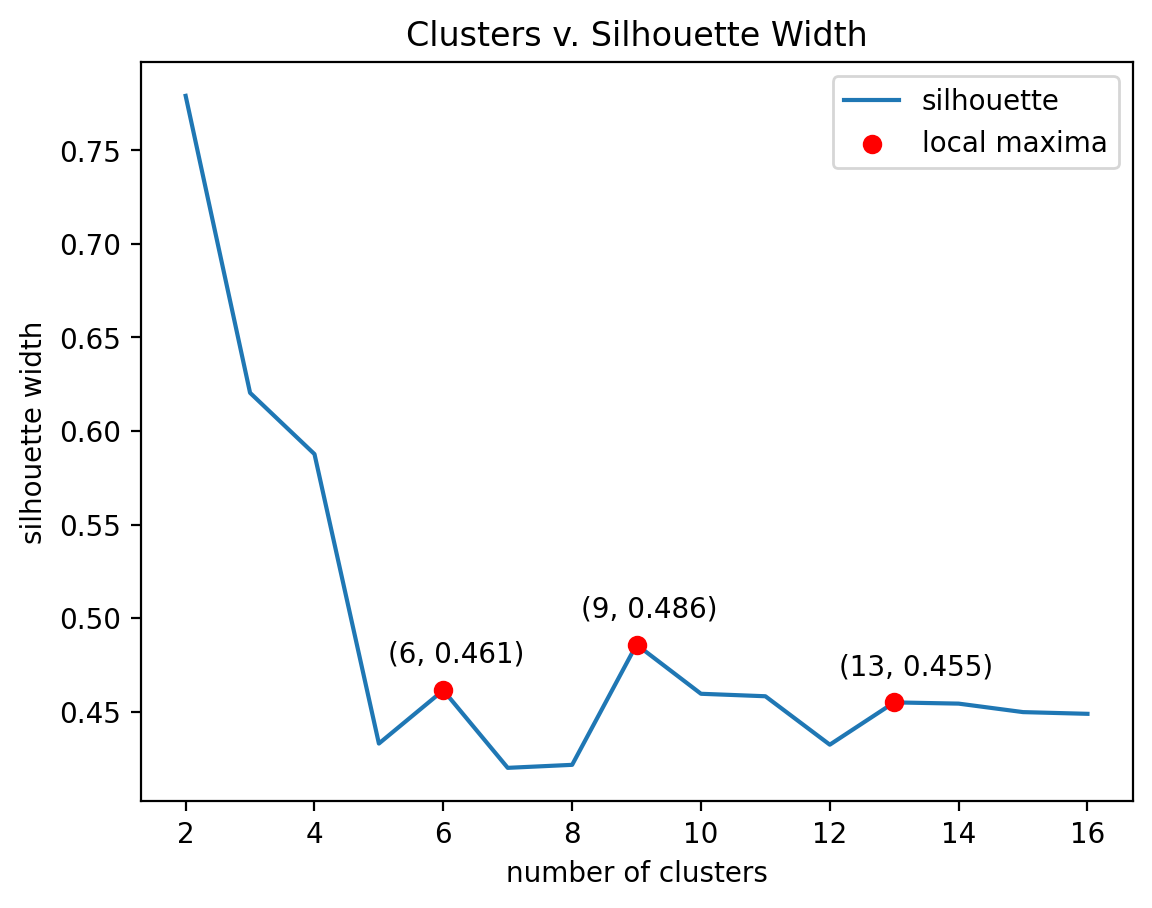

In [ ]:
import pandas as pd
from matplotlib import rcParams, rcParamsDefault, pyplot

rcParams.update(rcParamsDefault)

df = pd.read_csv(OUTPUT_DIRECTORY + f'silhouettes/{MIN_NUM_STATES}-{MAX_NUM_STATES}widths4.csv',
                 names=['clusters', 'silhouette']).drop(0)
df['silhouette'] = df['silhouette'].astype('float32')

# Get local maxima
maxima = {}
sils = df['silhouette']
for i, x in enumerate(sils):
    if x and i > 1 and i < MAX_NUM_STATES:
        if sils[i-1] < sils[i] and sils[i+1] < sils[i]:
            maxima[i] = sils[i]

print('local maxima:', maxima)
pyplot.clf()
ax = df.plot(x='clusters')
ax.set_title('Clusters v. Silhouette Width')
ax.set_xlabel('number of clusters')
ax.set_ylabel('silhouette width')
ax.scatter(x=list(maxima.keys()), y=list(maxima.values()), c='r',
           label='local maxima', zorder=2)
for x in maxima:
    ax.annotate(str((x, round(maxima[x], 3))), (x, maxima[x]), xytext=(-20,10), textcoords='offset points')
ax.legend()
pyplot.show()

#Output some files that describes these functions

The big takeaways are in your **aggregated_models** folder. These files show how often each chord is in which function, and how often the functions transition to one another.

While this process outputs information about each number of hidden states/functions **check the graph in the previous cell to determine which solutions are optimal**

For more under-the-hood granularity, the **improved_sils** folder shows exactly what events are analyzed in which function for each number of functions.

In [ ]:
#@title makeSilinfoBetter.py
import csv
import os
import numpy
import pandas as pd

IDinfo = "Silinfo"

impSils = OUTPUT_DIRECTORY + 'improved_sils/'
if 'improved_sils' not in os.listdir(path=OUTPUT_DIRECTORY):
    os.mkdir(impSils)
else:
    for f in os.listdir(path=impSils):
        os.remove(impSils + f)

aggDir = OUTPUT_DIRECTORY + 'aggregated_models/'
if 'aggregated_models' not in os.listdir(path=OUTPUT_DIRECTORY):
    os.mkdir(aggDir)
else:
    for f in os.listdir(path=aggDir):
        os.remove(aggDir + f)

for numberOfClusters in range(MIN_NUM_STATES, MAX_NUM_STATES+1):
    transition_matrix = numpy.zeros((numberOfClusters, numberOfClusters), dtype=int)
    emission_matrix = {}
    states_dir = OUTPUT_DIRECTORY + f'states{numberOfClusters}'
    files = os.listdir(states_dir)
    viterbi_fname = [f for f in files if f.endswith(f'run{WHICH_RUN}-viterbi.csv')][0]
    originalCSV = csv.reader(open(OUTPUT_DIRECTORY + 'silhouettes/' + str(numberOfClusters) + IDinfo + "4.csv", "r"))
    outFile = open(impSils + str(numberOfClusters) + IDinfo + f"modifiedSilinfo{WHICH_RUN}.csv", "w")
    newCSV = csv.writer(outFile)
    tempOut = open(impSils + "temp.csv", "w")
    temp = csv.writer(tempOut)
    next(originalCSV)

    viterbiReader = csv.reader(
        open(
            OUTPUT_DIRECTORY + f'states{numberOfClusters}/' + viterbi_fname,
            "r",
        )
    )
    next(viterbiReader)

    """
    #######JUST FOR METER#######
    beatStrengthReader = csv.reader(open('/users/christopherwhite/Documents/python2/Meter/pulsesToEighthNote.csv', 'r'))
    dictOfStrenghts = {}
    for rowY in beatStrengthReader:
        piece = rowY[0]
        onset = rowY[1]
        if onset == "offset": continue
        onset = str(float(onset))
        if onset == '0': onset = '0.0'
        strength = rowY[3]
        signature = rowY[4]
        if piece not in dictOfStrenghts:
            dictOfStrenghts[piece] = {}
        dictOfStrenghts[piece][onset] = [strength, signature]
    print dictOfStrenghts

    #############################
    """

    orderedListOfRows = {}

    for i, row in enumerate(originalCSV):
        chordAndSlice = row[0].split("_")
        cluster = row[1]
        neighbor = row[2]
        silWidth = round(float(row[3]), 3)
        # print(cluster)
        newRow = [chordAndSlice[1], chordAndSlice[0], cluster, neighbor, silWidth]
        orderedListOfRows[str(chordAndSlice[1])] = newRow


    topRow = [
        "Slice",
        "Piece",
        "Segment",
        "Offset",
        "PrevChord",
        "Chord",
        "NextChord",
        "PrevCluster",
        f"Cluster{numberOfClusters}",
        "NextCluster",
        "neighbor",
        "silWidth",
        "strength",
        "sign",
    ]
    previousCluster = ""
    previousPiece = ""
    indexesWherePieceChanges = []
    for i, row in enumerate(viterbiReader):
        if str(i) not in orderedListOfRows:
            # print(i, "is not here")
            continue
        clusterRow = orderedListOfRows[str(i)]
        piece = row[0]
        segment = row[1]
        offset = row[2]
        prevChord = row[4]
        slice, chord, cluster, neighbor, silWidth = clusterRow
        if i < len(orderedListOfRows) - 1:
            nextChord = orderedListOfRows[str(i + 1)][1]
            nextCluster = orderedListOfRows[str(i + 1)][2]
        else:
            # print("I should be on the last one")
            nextChord = "-"
            nextCluster = "-"
        # THESE ARE JUST HERE FOR METER
        # try:
        # 	strength = dictOfStrenghts[piece][offset][0]
        # except:
        # 	print "there's no piece", piece, "here"
        # 	continue
        # sign = dictOfStrenghts[piece][offset][1]
        # print strength
        # rowForWriting = [slice, piece, segment, offset, prevChord, chord, nextChord, previousCluster, cluster, nextCluster, neighbor, silWidth, strength, sign]
        rowForWriting = [
            slice,
            piece,
            segment,
            offset,
            prevChord,
            chord,
            nextChord,
            previousCluster,
            cluster,
            nextCluster,
            neighbor,
            silWidth,
        ]
        try:
            transition_matrix[int(cluster)-1, int(nextCluster)-1] += 1
        except ValueError:
            pass
        try:
            emission_matrix[chord][int(cluster)-1] += 1
        except KeyError:
            emission_matrix[chord] = numpy.zeros((numberOfClusters), dtype=int)
            emission_matrix[chord][int(cluster)-1] += 1

        temp.writerow(rowForWriting)
        previousCluster = cluster
        if piece != previousPiece:
            indexesWherePieceChanges.append(i)
        previousPiece = piece
    tempOut.close()
    temp1 = csv.reader(open(impSils + "temp.csv", "r"))
    newCSV.writerow(topRow)
    previousPiece

    for i, row in enumerate(temp1):
        # print('row is', row)
        # take care of beginnings of pieces
        if i in indexesWherePieceChanges:
            # change prevChord, previousCluster
            row[4] = "-"
            row[7] = "-"
        # take care of endings of pieces
        if i + 1 in indexesWherePieceChanges:
            # change nextChord, nextCluster
            row[6] = "-"
            row[9] = "-"
        newCSV.writerow(row)

    outFile.close()
    os.remove(impSils + 'temp.csv')

    agg_csv = open(aggDir + f'{numberOfClusters}-aggregatedModel.csv', 'w')
    agg_csv.write('Transition Matrix\n')
    transitions_df = pd.DataFrame(transition_matrix)
    transitions_df.columns = [i+1 for i in transitions_df.columns]
    transitions_df.index = [i+1 for i in transitions_df.index]
    transitions_df.to_csv(agg_csv)
    agg_csv.write('\nEmission Matrix\n')
    emissions_df = pd.DataFrame(emission_matrix).transpose()
    emissions_df.columns = [i+1 for i in emissions_df.columns]
    emissions_df.to_csv(agg_csv)
    agg_csv.close()


In the "improved_sils" folder in your working directory, the results should look like this:

|Slice      |Piece|Segment|Offset      |PrevChord |Chord     |NextChord |PrevCluster|Cluster2|NextCluster|neighbor|silWidth|strength|sign|
|-----------|-----|-------|------------|----------|----------|----------|-----------|--------|-----------|--------|--------|--------|----|
|0          |n.II |1      |0           |-         |[0, 4, 7] |[11, 2, 5]|-          |1       |2          |2       |0.975   |        |    |
|1          |n.II |1      |1           |[0, 4, 7] |[11, 2, 5]|[0, 4, 7] |1          |2       |1          |1       |0.971   |        |    |
|2          |n.II |1      |2           |[11, 2, 5]|[0, 4, 7] |[5, 9, 0] |2          |1       |2          |2       |0.975   |        |    |
| ...



In the aggregated_runs folder, the csvs tiled x-aggregatedModel.csv look like this:

Transition Matrix:

|           |1  |2  |
|-----------|---|---|
|1          |15 |87 |
|2          |87 |9  |

Emission Matrix:

|           |1  |2  |
|-----------|---|---|
|[0, 4, 7]  |54 |0  |
|[11, 2, 5] |0  |12 |
|[5, 9, 0]  |0  |12 |
|...
|[8, 0, 3]  |0  |2  |

*These outpus have been aligned with a particular version of the model. If you want to align your output with a different run, change the WHICH_RUN global variable.*

